In this post, I propose and implement a method of quality ranking scotches that attempts to remove as much as possible the preferences and tasting ability of raters from influencing the ultimate ranking results. First, I define the ranking method, then I implement it, generating a list of the "best" scotches.

#### Method

To rank scotches, one first needs to specify a set of criteria by which to judge every scotch. Once those criteria are defined, the "best" scotches will be those that rank most highly according to the criteria. I propose complexity and balance as the essential criteria to judge scotch. (These criteria are based upon Brooks in Whisky and Philosophy.) 

Imagine the ideal or perfect scotch. According to one theory, that scotch would possess all the possible flavors that a scotch could possess. For example, it would be fruity, smoky, peaty, et cetera. A scotch that possesses a large number of the possible flavors that a scotch could posses is called complex or multidimensional. In additional, in the ideal scotch each of the flavors would be distinct, not muddled, and discernible. No small group of flavors would dominate all of the others. If a scotch possesses this quality, it is called balanced. So not only does the ideal scotch possess a large number of flavors, it possess them in right proportion to one another so that all are identifiable. 

The complex and balanced a scotch is, the more closely it approximates the ideal scotch and the higher it ranks according to this method.

#### Implementation

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.2)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
file_name = 'whiskies_w_coords.csv'
top_scotches_to_map = 5

In [4]:
data = pd.read_csv(file_name)
to_rename = {
    'whiskies.Latitude':'FinalLat',
    'whiskies.Longitude':'FinalLong'
}
data = data.rename(columns=to_rename)
data = data.set_index('Distillery')
data = data.loc[:,'Body':]

In [5]:
flavors = data.loc[:, 'Body':'Floral']
location = data.loc[:, 'FinalLat':]

How can one actually implement this method of ranking scotches? Before I answer that question, I will describe the data are used as inputs to the method. The data, which can be sourced from this site [source], describe the range and intensity of flavors that are present in a given scotch. The data set has 12 columns; each one corresponding to a different flavor that may be present in scotch, for example sweetness, smoky, honey, or floral. Each row of the data set corresponds to a distillery, and each distillery is only represented by a single record. You may ask, how is each distillery able to be represented by single record? The reason is that each distillery is rated based upon its most popular issuance. Each distillery is rated from 0 to 4 in each flavor category; 0 being low/no intensity to 5 being high intensity. The 0 to 4 ratings were assigned initially by a small panel of experts, then passed around to various other members of the whisky industry for feedback. See [source] for more info on the data and the details of the original analysis, including clustering and principal component analysis, done with this data

In [6]:
flavors.head()

,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
Distillery,,,,,,,,,,,,
Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2
Aberlour,3,3,1,0,0,4,3,2,2,3,3,2
AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2
Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0
Ardmore,2,2,2,0,0,1,1,1,2,3,1,1


In [7]:
location.head()

,FinalLat,FinalLong
Distillery,,
Aberfeldy,-3.850199,56.625191
Aberlour,-3.229644,57.467395
AnCnoc,-2.785295,57.441751
Ardbeg,-6.108503,55.640607
Ardmore,-2.743629,57.350557


Using the data described above, one can calculate quantitatve measures of both complexity and balance and then rank scotches based upon these measures. First, I capture complexity by counting the number of characteristics with non-zero intensity rating; I refer to this count as the "complexity score." Second, I capture balance by calculating the mean flavor intensity divided by standard deviation of flavor intensities; I refer to the mean divided by the standard devation as the "balance score." A postive correlation between mean intensity and the balance score is meant to capture the idea that a more intense flavor overall is better than a less intense one. A negative correlation between standard deviation and the balance score is meant to capture the idea being that a scotch with similar ratings across flavor categories is more balanced than one with more disparate flavor intensities. In summary, "balance" increases as mean flavor intensity increases and decreases as the standard deviation of flavor intensities increases.

Calculate the "complexity" score.

In [8]:
flavors_count = flavors != 0
ratings = pd.DataFrame()
ratings['ComplexityScore'] = flavors_count.sum(axis=1)

Calculate the "balance" score.

In [9]:
ratings['Mean'] = flavors.mean(axis=1)
ratings['Std'] = flavors.std(axis=1)
ratings['BalanceScore'] = ratings['Mean']/ratings['Std']

In [10]:
ratings.head()

,ComplexityScore,Mean,Std,BalanceScore
Distillery,,,,
Aberfeldy,10,1.583333,0.792961,1.996734
Aberlour,10,2.166667,1.267304,1.709665
AnCnoc,8,1.416667,1.164500,1.216545
Ardbeg,8,1.583333,1.621354,0.976550
Ardmore,10,1.333333,0.887625,1.502135


The complexity and balance scores must then be combined in such a way so as to create a single ranking of all scotches. I have chosen to keep the ranking scheme as simple as possible so to generate the final ranking of I sort all of the scotches in descending order first by complexity score, then by balance score. The scotches listed at the top of the resulting ranking are the "best" according to the complexity and balance criteria. 

Due to sorting by complexity first, this ranking scheme does permit a scotch with a lower balance score but higher complexity score to be ranked higher than one with a higher balance score but lower complexity score. I'm not sure if that's a feature or a bug of the scheme, but it is more intuitively appealing to me than the reverse situation. Complexity seems like a more fundamental property than balance, that is, a complex but less balanced whisky should be ranked higher than a balanced though relatively simple one.

In [11]:
by_count_score = ratings.sort_values(by=['ComplexityScore', 'BalanceScore'], ascending=False).reset_index()
by_score_count = ratings.sort_values(by=['BalanceScore', 'ComplexityScore'], ascending=False).reset_index()

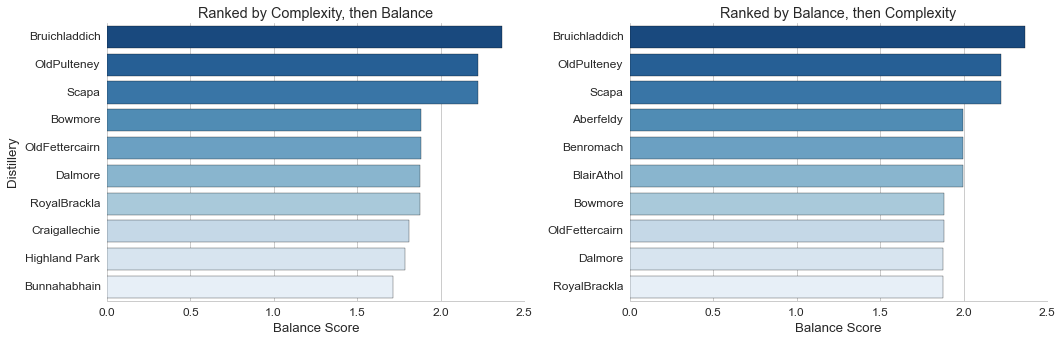

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='BalanceScore', y='Distillery', data=by_count_score[:10],palette="Blues_r", ax=ax1)
ax1.set(title='Ranked by Complexity, then Balance', xlabel="Balance Score", xlim=(0,2.5))

sns.barplot(x='BalanceScore', y='Distillery', data=by_score_count[:10],palette="Blues_r", ax=ax2)
ax2.set(ylabel='', title='Ranked by Balance, then Complexity', xlabel="Balance Score", xlim=(0,2.5))

# Finalize the plot
sns.despine(bottom=False, left=True)
plt.tight_layout(h_pad=3)

A question that came to mind as I was generating this ranking was, are the top scotches generally produced in a specific geographical area of Scotland?

In [15]:
map_data = by_count_score.head(top_scotches_to_map).merge(location, how='left', left_on='Distillery', right_index=True)

In [17]:
map_data.reset_index().loc[:,['FinalLat','FinalLong','Distillery']].to_csv('top_scotches.csv')

What does map tell us?

One weakness of this ranking scheme is that the correct order of sorting, that is, by complexity then balance, or vice versa, is not clear. And the order chosen does at least partially affect the results of the algorithm. Another option would be to somehow combine the complexity and balance scores into a single score, thus eliminating the issue all together.

so now that we have determined the best or ideal scotches that doesn't mean you will like them. that's preference based. and tasting ability.

if ranking is not indicative of highest quality scotches, why might that be? essential component of flavor or something else missing? flavor classification is not? advertisment, quality is responsible for notierity of certain brands. our definition of "best" differs from how most judge whisky. for example, the smoky islay scotches won't be at the top of the list due to their extreme flavor profile, though interestingly the top ranked scotch is from islay, just not one of the smoky guys. notice this rating system is all about balance.

now that we have a rating. we can potentially calculate the best value by taking into account price as well. divide by price?

can also use this method for evaluating a variety of "goods", like a husband or wife, an apartment, etcetc


use experts to describe characteristics of whisky but not determine rank. we are interested in a rating/ranking scheme, not a classification one.

have characteristics concerning smell and taste, missing others? like visual ones?

references: 
1. "The Ideal Scotch" by Thom Brooks in "Whiskey and Philosophy"
2. http://whiskyanalysis.com/index.php/methodology-introduction/methodology-flavour-comparison/
3. https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html- 